# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
from tqdm.notebook import tqdm

from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

2025-03-12 17:01:48.122886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741798908.130665  140398 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741798908.133054  140398 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741798908.141509  140398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741798908.141517  140398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741798908.141519  140398 computation_placer.cc:177] computation placer alr

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [3]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

In [4]:
from utils.visualization_funcs import plot_random_images_bbox

## Paths Setup

In [5]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [6]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [7]:
from pathlib import Path

DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

MODEL_CHECKPOINT = Path(cfg.OUTPUTS.CHECKPOINT_PATH)

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {v: k for k, v in enumerate(CLASS_NAME)}
class_map[CLASS_NAME[0]]

0

## Dataset Download from Roboflow

In [8]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    # https://universe.roboflow.com/roboflow-100/brain-tumor-m2pbp/dataset/2/images?split=test
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("tensorflow")

## Load images from directory

In [9]:
from utils.utils import pad_cls_id_bbx
from utils import utils

def _prepare_ds(img_list, cls_id_list, bbx_list):
    padded_class_ids, padded_bbx = pad_cls_id_bbx(cls_id_list, bbx_list)
    datasets = tf.data.Dataset.from_tensor_slices((img_list, padded_class_ids, padded_bbx))
    ds = datasets.map(utils.load_dataset, num_parallel_calls=tf.data.AUTOTUNE) 
    ds = ds.map(utils.preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return ds


In [ ]:
from data_handler.annotation_processor import AnnotationProcessor
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
test_images, test_class_ids, test_bboxes  = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)
test_ds = _prepare_ds(test_images, test_class_ids, test_bboxes)



I0000 00:00:1741798915.424444  140398 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7195 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


## Load the model

In [13]:
import keras
# model = keras.models.load_model(str(MODEL_CHECKPOINT/'chpt_49.keras'))
model = keras.models.load_model('output/checkpoints/ckpt_49.keras')

/code/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 56 variables whereas the saved optimizer has 110 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
results = model.evaluate(test_ds, return_dict=True)
results

 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - bounding_box_loss: 0.1183 - bounding_box_mse: 0.1183 - classification_AUC: 0.1641 - classification_f1_score: 0.6667 - classification_loss: 0.3961 - classification_precision: 0.9714 - classification_recall: 0.8500 - loss: 9.2662

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bounding_box_loss: 0.1154 - bounding_box_mse: 0.1154 - classification_AUC: 0.3686 - classification_f1_score: 0.6378 - classification_loss: 0.4451 - classification_precision: 0.9659 - classification_recall: 0.8467 - loss: 9.3122


{'bounding_box_loss': 0.11261286586523056,
 'bounding_box_mse': 0.11264051496982574,
 'classification_AUC': 0.36045384407043457,
 'classification_f1_score': 0.6349982023239136,
 'classification_loss': 0.46461018919944763,
 'classification_precision': 0.966576337814331,
 'classification_recall': 0.8451817035675049,
 'loss': 9.328341484069824}

In [19]:
unnorm_bbx = []
for bbx in test_bboxes:
   unnorm_bbx.append(bbx*IMG_SIZE)

In [ ]:
import random


def plot_random_images_bbox(*,  random_samples:np.ndarray, image_paths:np.ndarray, class_ids:np.ndarray, bboxes:np.ndarray, class_map:dict) -> None:
  fig = plt.figure(figsize=(8, 8))

  print(f"Random samples: {random_samples}")
  class_map_invert = {v: k for k, v in class_map.items()}
  
  for i, idx in enumerate(random_samples):
    ax = fig.add_subplot(3, 3, i+1)
    image = image_paths[idx]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Create title from class IDs
    title_labels = [class_map_invert[int(cls_id)] for cls_id in class_ids[idx]]
    title = ", ".join(title_labels)
    ax.set_title(title)
    ax.imshow(image) #display image before bounding box

    # Draw bounding boxes with different colors
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0,255,255), (255,0,255)] # Example colors
    for j, (xmin, ymin, xmax, ymax) in enumerate(bboxes[idx]):
        color = colors[j % len(colors)] # Cycle through colors
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 1)
    ax.imshow(image) #display image with bounding box.

  plt.tight_layout() #prevents overlapping subplots
  plt.show()

Random samples: [649, 949, 376, 476, 695, 241, 216, 551, 230]


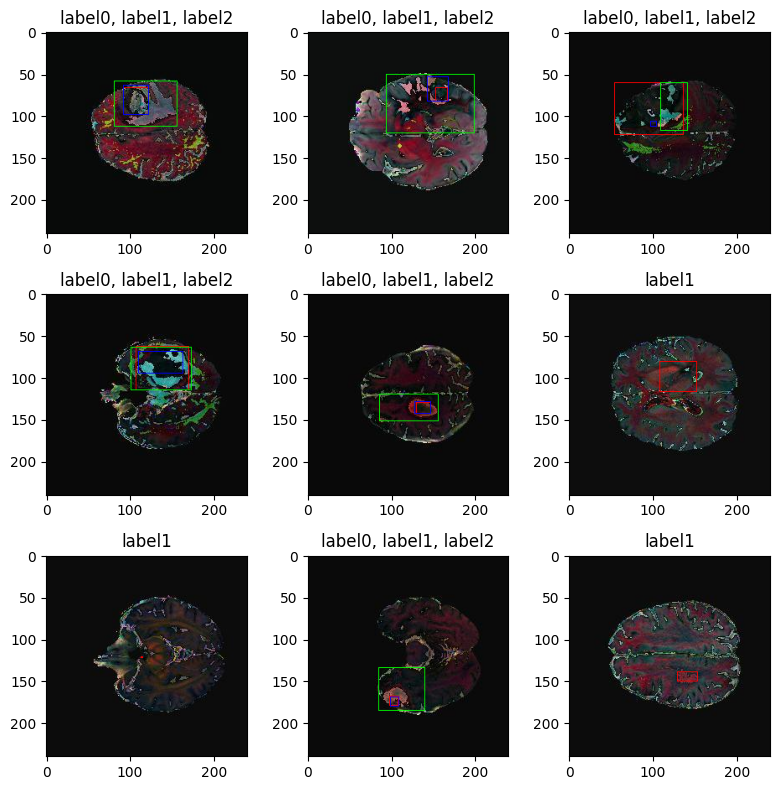

In [31]:
random_samples = random.sample(range(len(test_images)), 9)
plot_random_images_bbox(random_samples=random_samples,
                        image_paths=test_images, 
                        class_ids=test_class_ids, 
                        bboxes=unnorm_bbx,
                        class_map=class_map)

In [54]:
pred_cls_id, pred_bbx = model.predict(test_ds)
print(pred_cls_id.shape, pred_bbx.shape)

 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
(990, 3) (990, 3, 4)


In [55]:
pred_bbx

array([[[ 0.0367163 ,  0.02746374,  0.11039032,  0.07692052],
        [ 0.11618149,  0.20362097,  0.16175756,  0.12798452],
        [ 0.1974205 ,  0.14364155,  0.16032316,  0.14926872]],

       [[ 0.15539496,  0.05715334,  0.23768109,  0.11665768],
        [ 0.15373884,  0.11551596, -0.00631157, -0.0145406 ],
        [ 0.15454629, -0.0820144 ,  0.0924191 ,  0.12791984]],

       [[ 0.5494976 ,  0.19886778,  0.853205  ,  0.23527278],
        [ 0.4757411 ,  0.2839789 ,  0.02722448, -0.18174133],
        [ 0.49266282, -0.15816604,  0.16510814,  0.5521452 ]],

       ...,

       [[ 0.1360329 ,  0.12108732,  0.20494685,  0.19356139],
        [ 0.09758659,  0.28330663,  0.27654162,  0.24706168],
        [ 0.12567747,  0.12780954,  0.22111426,  0.17579423]],

       [[ 0.2815983 ,  0.11195467,  0.4181737 ,  0.16165245],
        [ 0.29601792,  0.16921747,  0.02762191, -0.0343315 ],
        [ 0.24133272, -0.04228279,  0.15525506,  0.2191858 ]],

       [[ 0.232036  ,  0.1772023 ,  0.31844115,

In [56]:
unnorm_pred_bbx = []
for bbx in pred_bbx:
   unnorm_pred_bbx.append(bbx*IMG_SIZE)

In [69]:
pred_cls_id = (pred_cls_id>0.5).astype(int)
pred_cls_id

array([[1, 1, 1],
       [1, 1, 0],
       [1, 1, 0],
       ...,
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0]])

In [70]:
pred_cls = [np.where(row==1)[0].tolist() for row in pred_cls_id]
pred_cls

[[0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1, 2],
 

In [71]:
for idx in random_samples:
   print([cls_id for cls_id in pred_cls[idx]])

[0, 1, 2]
[0, 1]
[0, 1]
[0, 1, 2]
[0, 1, 2]
[0, 1]
[0, 1]
[0, 1]
[0, 1, 2]


In [1]:
plot_random_images_bbox(random_samples=random_samples,
                        image_paths=test_images, 
                        class_ids=pred_cls, 
                        bboxes=unnorm_pred_bbx,
                        class_map=class_map)

NameError: name 'plot_random_images_bbox' is not defined

In [76]:
unnorm_bbx, pred_bbx

([array([[ 95., 123., 165., 166.]]),
  array([[190., 138., 202., 158.],
         [186., 157., 187., 159.]]),
  array([[ 93., 142., 125., 171.],
         [ 90., 135., 136., 176.],
         [ 85., 140., 129., 176.]]),
  array([[137.,  66., 152.,  83.],
         [105.,  57., 177., 111.],
         [134.,  66., 153.,  90.]]),
  array([[ 74.,  82.,  97., 100.]]),
  array([[100.,  98., 122., 110.]]),
  array([[ 65.,  78., 101., 102.],
         [ 54.,  72., 120., 125.],
         [ 59.,  76., 104., 107.]]),
  array([[113., 120., 159., 154.]]),
  array([[ 58., 126., 129., 164.],
         [ 52., 120., 147., 162.],
         [ 56., 126., 131., 168.]]),
  array([[120.,  54., 192., 107.]]),
  array([[110.,  82., 153., 129.],
         [116.,  77., 159., 128.],
         [124.,  96., 153., 121.]]),
  array([[ 89., 123., 155., 181.],
         [ 84., 107., 193., 181.],
         [ 96., 129., 134., 166.]]),
  array([[111., 141., 122., 149.]]),
  array([[115., 163., 117., 168.]]),
  array([[147., 100., 155.,

In [80]:
from src.losses.iou_loss import iou_metric
for y_tbbx, y_prdbbx in zip(unnorm_bbx, unnorm_pred_bbx):
    print(iou_metric(y_true=y_tbbx, y_pred=y_prdbbx)) 

tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)


2025-03-12 17:47:34.587445: W tensorflow/core/framework/op_kernel.cc:1844] INVALID_ARGUMENT: required broadcastable shapes
2025-03-12 17:47:34.587464: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: {{function_node __wrapped__Maximum_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Maximum] name: 